In [1]:
from functools import partial
import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from skimage.io import imread
from skimage.measure import find_contours

plt.rcParams['figure.figsize'] = (4.8 * 2, 3.6 * 2)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.facecolor'] = 'white'

## Step 1: Read image

Text(0.5, 1.0, 'Step 1: Read image')

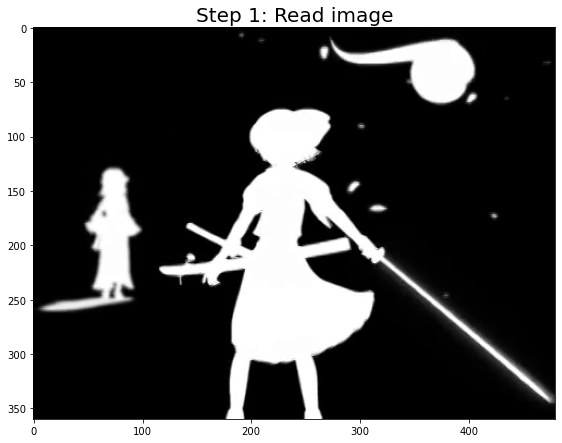

In [2]:
IMAGE = 'input/1822.png'
frame = imread(IMAGE, as_gray=True)

plt.imshow(frame, cmap='gray')
plt.title('Step 1: Read image')

In [3]:
def lims():
    """Adjusts plot limits. To be called after every plot"""
    plt.gca().set_aspect('equal', 'box')
    plt.xlim(0, frame.shape[1])
    plt.ylim(frame.shape[0], 0)

## Step 2: Compute contours

Text(0.5, 1.0, 'Step 2: Compute contours')

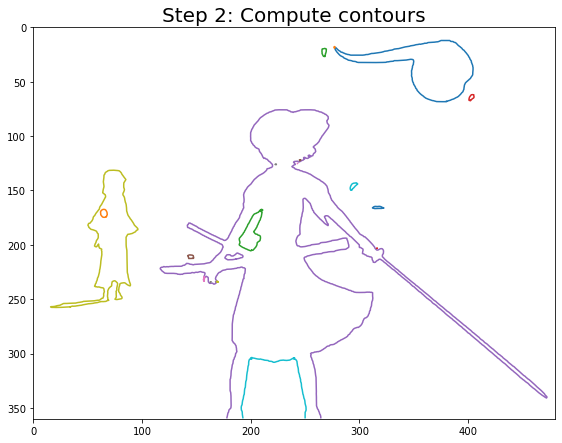

In [4]:
# Convert to complex numbers
zs = [c[:,1] + 1j*c[:,0] for c in find_contours(frame, .9)]

for z in zs:
    plt.plot(z.real, z.imag)
lims()
plt.title('Step 2: Compute contours')

## Step 3: Merge contours end to end (used for interpolation)

### Step 3.1: Compute timestamps for interpolation for each contour individually

Text(0.5, 1.0, 'Step 3.1: Interpolation for each contour')

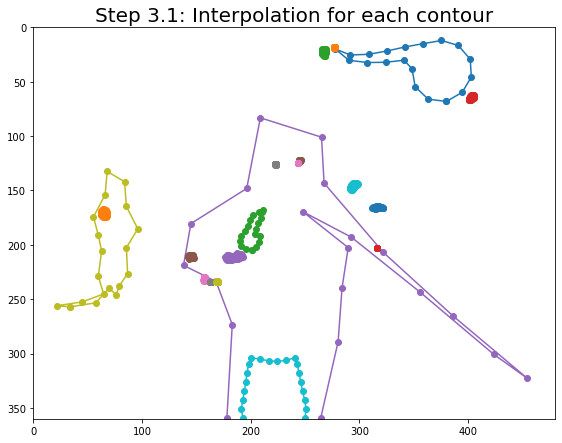

In [5]:
# Compute timestamps for each individual contour.
# Assume that we move along the contour with constant speed. 
# Therefore, the timestamps along each contour correspond to the distance travelled.
ts = [np.cumsum(np.abs(np.diff(z, prepend=z[0]))) for z in zs]

# Interpolate each contour with 20 points just for demonstration
for t, z in zip(ts, zs):
    c = np.interp(np.linspace(0, t[-1], 20), t, z)
    plt.plot(c.real, c.imag, '-o')
lims()
plt.title('Step 3.1: Interpolation for each contour')

### Step 3.2: Merge contours so that we can easily interpolate across all contours

Text(0.5, 1.0, 'Step 3.2: Canonical merged contour')

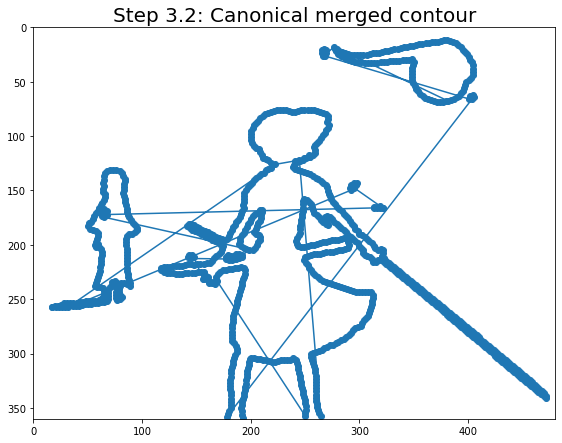

In [6]:
# Small delta time between each contour
JUMP_TIME = 10 ** -5

# Starting time of each individual contour
offsets = np.cumsum([0] + [t[-1] for t in ts[:-1]]) + np.arange(len(ts)) * JUMP_TIME

# Finally merge
t_canon = np.concatenate([t + o for t, o in zip(ts, offsets)])
z_canon = np.concatenate(zs)


# Interpolate accross all contour using 1000 points for demo
c = np.interp(np.linspace(0, t_canon[-1], 1000), t_canon, z_canon)
plt.plot(c.real, c.imag, '-o')
lims()
plt.title('Step 3.2: Canonical merged contour')

## Step 4: Solve Travelling Salesman Problem

### Step 4.1: Convert to TSP instance

The TSP graph will be fully connected and the costs between nodes will be equal to the euclidean distance between the nodes. However, we need to make sure that the TSP solution traverses all line segments on each individual contour. We will take each segment along each contour, add its 2 endpoints as vertices to our graph, and force the condition that the edge between these two vertices must be part of the solution.

Let's say we have a contour $ C $, with consecutive points $ (p_1, p_2, \ldots, p_n) $. Each individual segment $ s_k $, formed by points $ (p_k, p_{k+1}) $, with $ 0 \le k \lt n $ results in 2 new TSP vertices $ p_k^{start}, p_k^{end} $. These vertices are added to the TSP graph, and we later put the condition that every edge $ (p_k^{start}, p_k^{end}) $ must be traversed. 

Observations:
1. a contour $ C $ results in $2n-2$ vertices: $ \{p_1^{start}, p_1^{end}, p_2^{start}, p_2^{end}, \ldots, p_n^{start}, p_n^{end}\} $
2. $ p_k^{end} = p_{k+1}^{start} $ except for the endpoints

Text(0.5, 1.0, 'Step 4.1: TSP vertices')

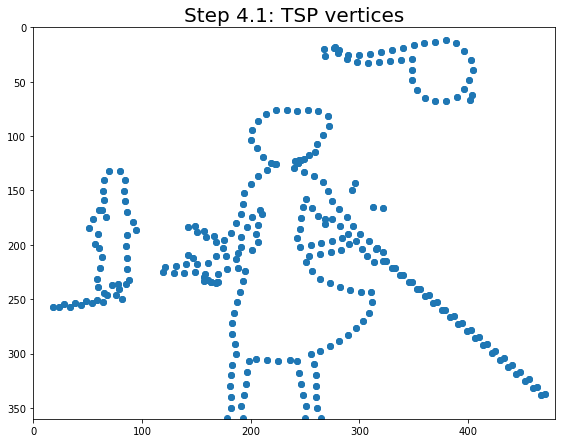

In [7]:
REDUCTION = 10  # Factor by which to downsample contours. 
                # If we don't downsample, the LKH solver takes a long time and the quality of the tour degrades.
    
MINPOINTS = 3  # Minimum points for each contour. Must be at least 2

# Canonical merged contour interpolation timestamp. 
# Required for reconstructing the contour from the TSP solution.
node_t_canon = []

# TSP node 2D coordinates
node_z_canon = []

# For each individual contour
for cnt, (t, z) in enumerate(zip(ts, zs)):
    # Downsample the contour through interpolation (like in step 3.1)
    tn = np.linspace(0, t[-1], max(round(t[-1] / REDUCTION), MINPOINTS))
    zn = np.interp(tn, t, z)

    # Timestamps for each node
    tn += offsets[cnt]
    tn = np.stack([tn[:-1], tn[1:]], axis=1).reshape(-1)
    node_t_canon.extend(tn)

    # Coordinates for each node
    zn = np.stack([zn[:-1], zn[1:]], axis=1).reshape(-1)
    node_z_canon.extend(zn)

# Edges that MUST be part of the solution
fixed_edges = np.arange(len(node_t_canon)).reshape(-1, 2)


tmp = np.array(node_z_canon)
plt.plot(tmp.real, tmp.imag, 'o')
lims()
plt.title('Step 4.1: TSP vertices')

### Step 4.2: Call the LKH-3 solver

In [8]:
LKH_EXEC = 'LKH-3.exe'

def run_LKH(node_coords, fixed_edges):
    """
    Helper function that sets up the necessary files and calls the solver. 
    See the LKH documentation.
    
    :param node_coords: List of vertex coordinates as complex numbers
    :param fixed_edges: List of pairs of node indices between which an edge must exist
    :return: List of indexes in the order in which they should be travelled
    """
    if len(node_coords) < 3:
        return list(range(len(node_coords)))

    problem_file = tempfile.NamedTemporaryFile('w', delete=False)
    solution_file = tempfile.NamedTemporaryFile('w', delete=False)
    parameter_file = tempfile.NamedTemporaryFile('w', delete=False)

    try:
        # Write input files
        problem_file.write('\n'.join([
            'TYPE:TSP',
            f'DIMENSION:{len(node_coords)}',
            'EDGE_WEIGHT_TYPE:EUC_2D',
            'NODE_COORD_SECTION:',
            *[f'{i + 1} {round(z.real * 1000)} {round(z.imag * 1000)}' for i, z in enumerate(node_coords)],
            'FIXED_EDGES_SECTION:',
            *[f'{n1 + 1} {n2 + 1}' for n1, n2 in fixed_edges],
            '-1',
        ]))
        parameter_file.write('\n'.join([
            f'PROBLEM_FILE={problem_file.name}',
            f'TOUR_FILE={solution_file.name}',
            'TRACE_LEVEL=0',
            'CANDIDATE_SET_TYPE=DELAUNAY',  # "DELAUNAY seems to work best"
        ]))

        # Close files
        problem_file.close()
        solution_file.close()
        parameter_file.close()

        # Run LKH process. You need to send a '\n' for the process to terminate... WHY?
        subprocess.run([LKH_EXEC, parameter_file.name], input='\n', text=True)

        # Get output
        with open(solution_file.name) as f:
            text = f.read()
        text = text.split('TOUR_SECTION\n', maxsplit=1)[1]
        text = text.split('\n-1', maxsplit=1)[0]

        nodes_tour = [int(n) - 1 for n in text.splitlines()]
    finally:
        for f in [problem_file, solution_file, parameter_file]:
            f.close()
            os.remove(f.name)

    return nodes_tour

Text(0.5, 1.0, 'Step 4.2: TSP tour')

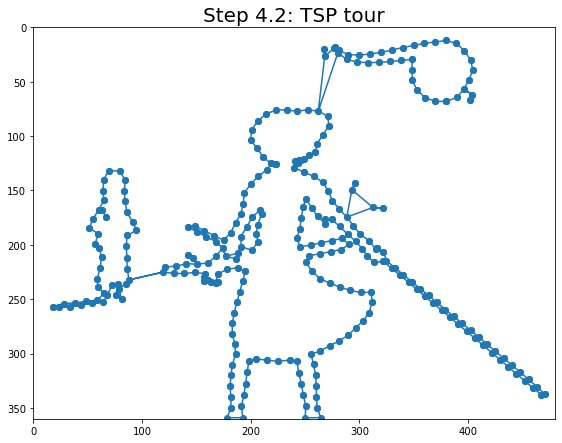

In [9]:
nodes_tour = run_LKH(node_z_canon, fixed_edges)


# Plot the tour
c = [node_z_canon[n] for n in nodes_tour]
c.append(c[0])
c = np.array(c)

plt.plot(c.real, c.imag, '-o')
lims()
plt.title('Step 4.2: TSP tour')

### Step 4.3: Interpolation for merged tour

We have the tour, but we would like to be able to increase the resolution as we please. The solution is to interpolate twice:
```python
t = np.linspace(0, t_t_tsp[-1], 1000)
t_tour = np.interp(t, t_t_tsp, t_z_tsp)  # Interpolate the timestamps from tour to canonical
z_tour = np.interp(t_tour, t_canon, z_canon)  # The actual coordinates
```

Text(0.5, 1.0, 'Step 4.3: Interpolation for merged tour')

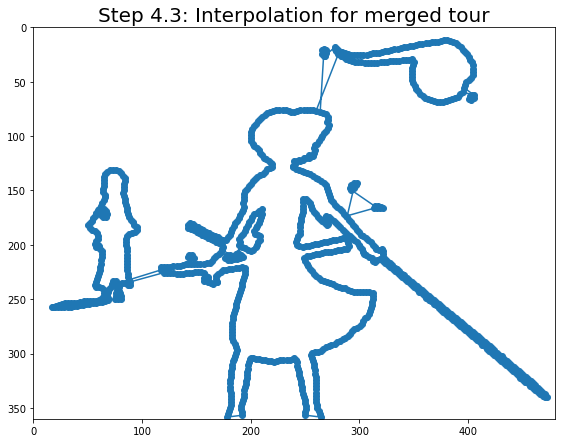

In [10]:
# Construct interpolation from new contour time to old contour time

jumps = []  # Keep track at what timestamps we switch contours. Useful for later

t_t_tsp = [0] * 2
t_z_tsp = [node_t_canon[nodes_tour[0]]] * 2

# For each segment in the tour, excluding those that start and end at the same point.
# Those always occur at [odd, even] indices.
for i in range(0, len(nodes_tour), 2):
    n12, n21 = nodes_tour[i : i + 2]
    t1, t2 = node_t_canon[n12], node_t_canon[n21]  # Original timestamps
    
    if t1 == t_z_tsp[-1]:
        # If this is not a jump
        t_t_tsp[-1] += abs(t2 - t1)
        t_z_tsp[-1] = t2
    else:
        # If this is a jump
        newt0 = t_t_tsp[-1] + JUMP_TIME
        newt1 = newt0 + abs(t2 - t1)
        jumps.append((t_t_tsp[-1], newt0))
        t_t_tsp.extend([newt0, newt1])
        t_z_tsp.extend([t1, t2])
jumps = np.array(jumps)


# Plot tour using 1000 points.
t = np.linspace(0, t_t_tsp[-1], 1000)
t_tour = np.interp(t, t_t_tsp, t_z_tsp)  # Interpolate the timestamps from tour to canonical
z_tour = np.interp(t_tour, t_canon, z_canon)  # The actual coordinates

plt.plot(z_tour.real, z_tour.imag, '-o')
lims()
plt.title('Step 4.3: Interpolation for merged tour')

### Step 4.nitpicking

1. Sometimes the first and last point of the tour might be the same because we ended on a closed contour. This slightly affects the FFT in the next step. If the first and last point are the same, we exclude the last point.
2. Interpolation across jumps looks weird if we use very few points. This is because the sampled points don't lie exactly at the start and end of the jumps. Therefore, we move points immediately followed or preceded by a jump, s.t. they lie exactly at the endpoints of the jump

In [11]:
npoints = 2**11  # Number of samples to use

# Get start and end points and check if they are the same.
# If they are, use `np.linspace(_,_,_, endpoint=False)`
start_z, end_z = np.interp(np.interp([0, t_t_tsp[-1]], t_t_tsp, t_z_tsp), t_canon, z_canon)
endpoint = not np.isclose(start_z, end_z)  # Exclude end point if it equals start point

t_t_tour = np.linspace(0, t_t_tsp[-1], npoints, endpoint=endpoint)

Text(0.5, 1.0, 'Step 4.nitpicking: It looks pretty much the same')

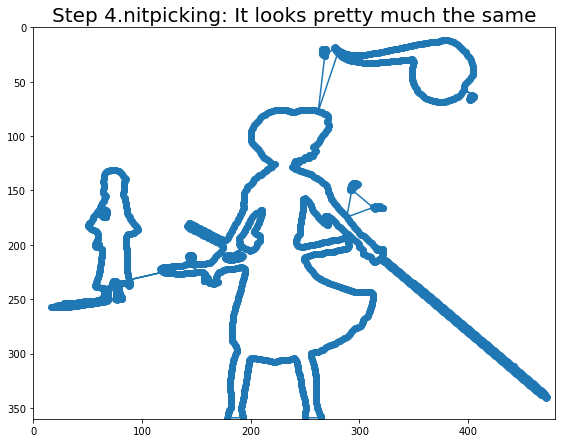

In [12]:
# Move points immediately followed or preceded by a jump, s.t. they lie exactly at the endpoints of the jump
if len(jumps):
    jump_idxs = t_t_tour.searchsorted(jumps)
    jump_idxs[:,0] -= 1
    jump_idxs = jump_idxs.ravel()
    cond = jump_idxs < len(t_t_tour)
    jump_idxs = jump_idxs[cond]
    jumps_ravel = jumps.ravel()[cond]
    t_t_tour[jump_idxs] = jumps_ravel  # Make sure that segments end and start on a jump
t_tour = np.interp(t_t_tour, t_t_tsp, t_z_tsp)
z_tour = np.interp(t_tour, t_canon, z_canon)


plt.plot(z_tour.real, z_tour.imag, '-o')
lims()
plt.title('Step 4.nitpicking: It looks pretty much the same')

## Step 5: Remove FFT frequencies

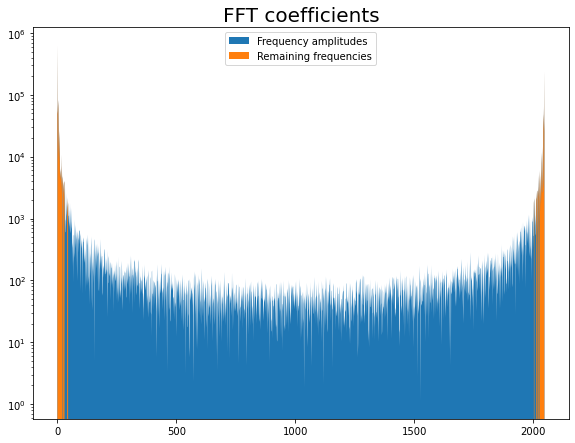

In [13]:
# FFT
coefs = np.fft.fft(z_tour)

# Keep only first 80 frequencies + 1 constant component
arg_coefs = np.argsort(np.abs(coefs))
cut_coefs = coefs.copy()
cut_coefs[arg_coefs[:len(arg_coefs) - 1 - 80]] = 0


plt.fill_between(np.arange(len(coefs)), np.abs(coefs), label='Frequency amplitudes')
plt.fill_between(np.arange(len(coefs)), np.abs(cut_coefs), label='Remaining frequencies')
plt.yscale('log')
plt.title('FFT coefficients')
plt.legend(loc='upper center')

Text(0.5, 1.0, 'Step 5: Remove FFT frequencies')

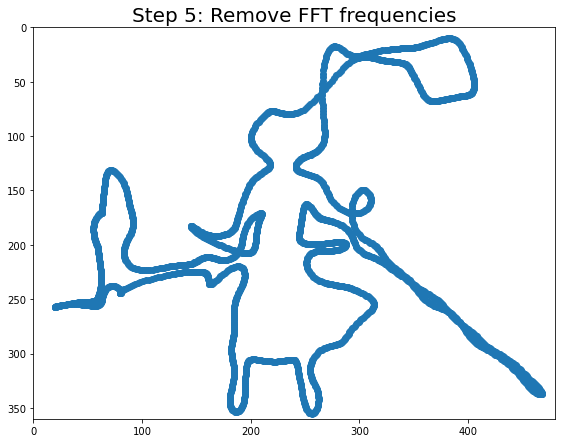

In [14]:
# Reconstruct contour
z_fft = np.fft.ifft(cut_coefs)

# Close contour
z_fft = np.append(z_fft, z_fft[0])

plt.plot(z_fft.real, z_fft.imag, '-o')
lims()
plt.title('Step 5: Remove FFT frequencies')

## Step 6: Transparent contour based on sample distances

Portions of the contour where samples are more sparse become more transparent. This way, we can see where jumps occur.

Text(0.5, 1.0, 'Step 6: Transparent contour based on sample distances')

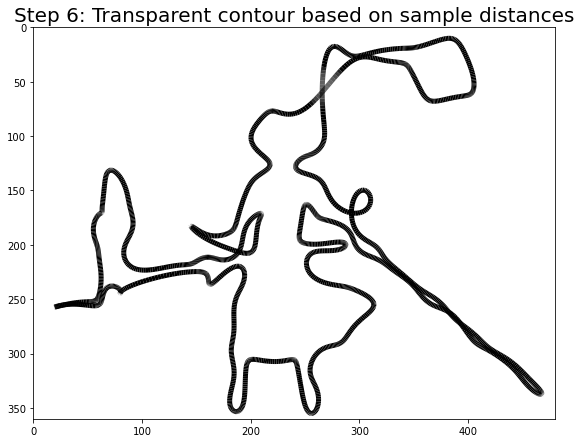

In [15]:
dists = np.abs(np.diff(z_fft))  # Distance between samples
colors = np.zeros((len(dists), 4))  # Black color for all segments
# Alter alpha based on `dists`
colors[:, 3] = np.minimum(np.exp(-dists + (t_t_tour[-1] / (npoints - 1) * 2)), 1)

# Split contour into individual segments, each with its own color
line = np.stack([z_fft.real, z_fft.imag], axis=-1)
lc = LineCollection(np.stack([line[:-1], line[1:]], axis=1), colors=colors, linewidth=5)


plt.gca().add_collection(lc)
lims()
plt.title('Step 6: Transparent contour based on sample distances')

## Step 7: Square waves

Instead of decomposing the contour into sinusoids with different frequencies, we can decompose the contour into many other arbitrary waveforms, for example complex square waves. See https://gitlab.com/floofnoodlecode/fourier-arbitrary-waveforms for an explanation on how this is achieved.

After following the steps from the above link in order to obtain the coefficients, the process is exactly the same as with the normal Fourier Transform.

### Setup some functions

In [16]:
def harmonic(y, k):
    """Helper function to return signal `y` with frequency `k`"""
    N = len(y)
    return y[np.arange(N) * k % N]

def calc_iA(y):
    """Compute inverse matrix `A`"""
    y = y / len(y)
    return np.linalg.inv(np.stack([harmonic(y, k) for k in range(len(y))]))

def dtft(iA, x):
    """
    Compute the frequency coefficients
    
    :param iA: Inverse of matrix `A`
    :param x: Signal `x` to decompose
    :return: Coefficients `c`
    """
    return iA @ x

def idtft(y, c):
    """
    Restore signal from frequency coefficients
    
    :param y: Base signal `y` used to decompose `x`
    :param c: Coefficients
    :return: Signal `x`
    """
    return np.sum([c[k] * harmonic(y, k) for k in range(len(y)) if c[k] != 0], axis=0) / len(y)

def sqw(N):
    """
    Square wave generator
    
    :param N: number of samples
    :return: Square wave signal
    """
    sqw = np.array([1 + 1j, -1 + 1j, -1 - 1j, 1 - 1j])
    return sqw[np.linspace(0, 4, N, endpoint=False).astype(int)]

Text(0.5, 1.0, 'Step 7: Square waves')

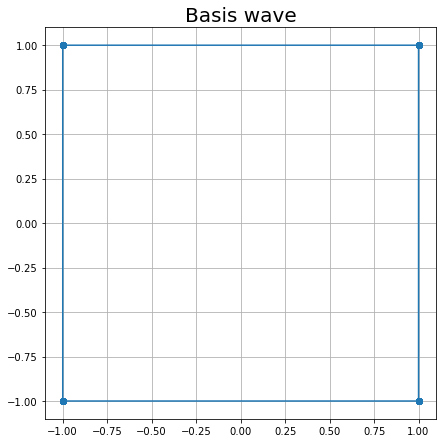

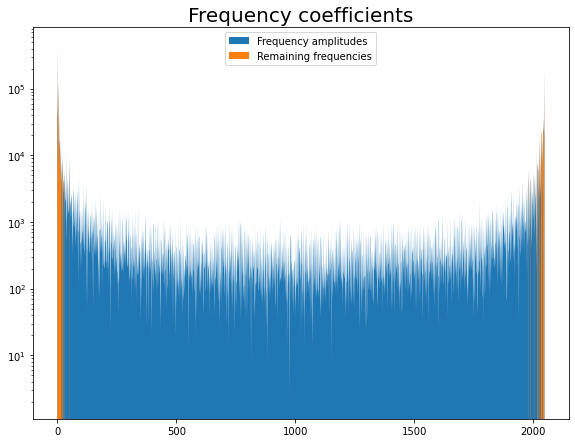

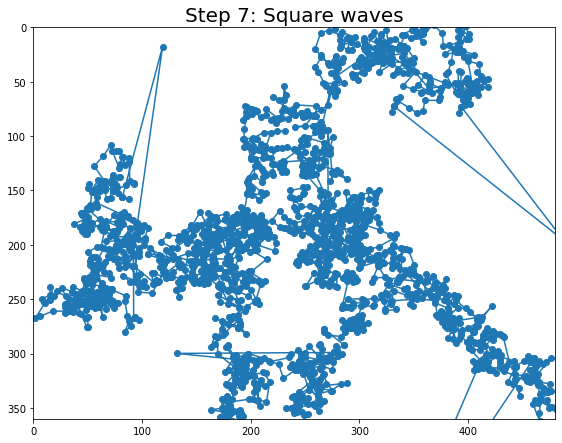

In [17]:
# Generate basis signal y
y = sqw(len(z_tour))

# Plot y
tmp = np.append(y, y[0])
plt.figure()
plt.plot(tmp.real, tmp.imag, '-o')
plt.title('Basis wave')
plt.axis('square')
plt.grid()

# Setup inverse of matrix A
iA = calc_iA(y)

# Compute coefficients
coefs = dtft(iA, z_tour)

# Keep only first 80 frequencies + 1 constant component
arg_coefs = np.argsort(np.abs(coefs))
cut_coefs = coefs.copy()
cut_coefs[arg_coefs[:len(arg_coefs) - 1 - 80]] = 0

# Plot coefficients
plt.figure()
plt.fill_between(np.arange(len(coefs)), np.abs(coefs), label='Frequency amplitudes')
plt.fill_between(np.arange(len(coefs)), np.abs(cut_coefs), label='Remaining frequencies')
plt.yscale('log')
plt.title('Frequency coefficients')
plt.legend(loc='upper center')

# Reconstruct contour
z_fft = idtft(y, cut_coefs)

# Close contour and plot
z_fft = np.append(z_fft, z_fft[0])
plt.figure()
plt.plot(z_fft.real, z_fft.imag, '-o')
lims()
plt.title('Step 7: Square waves')